# Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## План

1. Исследование, анализ данных. Выявление пропусков, ошибок, аномалий. 

2. Проверка хронологической корректности 

3. Уточняющие вопросы заказчику.

4. Приведение данных к виду позволяющему обучать модели. Удаление ошибок и аномальных значений, заполнение пропусков. Сведение в общую таблицу с учетом партий и хронологической последовательности.

5. Модели (разделить данные на тренировочную и тестовую выборки, обучить модели, выбрать лучшуюю)

6. Выводы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor




Загрузка данных:

In [2]:
try:
    data_arc = pd.read_csv('C:/ya_pr/steel/data_arc.csv')
    data_bulk = pd.read_csv('C:/ya_pr/steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('C:/ya_pr/steel/data_bulk_time.csv')
    data_gas = pd.read_csv('C:/ya_pr/steel/data_gas.csv')
    data_temp = pd.read_csv('C:/ya_pr/steel/data_temp.csv')
    data_wire = pd.read_csv('C:/ya_pr/steel/data_wire.csv')
    data_wire_time = pd.read_csv('C:/ya_pr/steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
title_df = {
    'Данные об электродах': data_arc,
    'Данные о подаче сыпучих материалов (объём)': data_bulk,
    'Данные о подаче сыпучих материалов (время)': data_bulk_time,
    'Данные о продувке сплава газом': data_gas,
    'Результаты измерения температуры': data_temp,
    'Данные о проволочных материалах (объём)': data_wire,
    'Данные о проволочных материалах (время)': data_wire_time
}

### 1 Общий обзор данных ###

In [4]:
for title in title_df:
    print()
    print('\033[1m' + '\033[92m' + title + '\033[0m')
    print()
    display(title_df[title].info())
    print()
    


Данные об электродах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None



Данные о подаче сыпучих материалов (объём)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None



Данные о подаче сыпучих материалов (время)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None



Данные о продувке сплава газом

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None



Результаты измерения температуры

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None



Данные о проволочных материалах (объём)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None



Данные о проволочных материалах (время)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Помотрим на конкретные примеры данных:

In [5]:
for title in title_df:
    print()
    print('\033[1m' + '\033[92m' + title + '\033[0m')
    print()
    display(title_df[title].head(15))
    print()


Данные об электродах



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494




Данные о подаче сыпучих материалов (объём)



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0




Данные о подаче сыпучих материалов (время)



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52




Данные о продувке сплава газом



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891




Результаты измерения температуры



,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0




Данные о проволочных материалах (объём)



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Данные о проволочных материалах (время)



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Технические выводы о качестве данных:**

- Все временные признаки, во всех таблицах представленны строковым типом. Переведем в формат datetime:

In [6]:
for title in title_df:
    for column in title_df[title].columns:
        if title_df[title][column].dtype == 'object':
            title_df[title][column] = pd.to_datetime(title_df[title][column], format='%Y-%m-%d %H:%M:%S')

 - В таблицах "Данные об электродах" и "Данные о продувке сплава газом" пропусков нет.
 - В таблице "Результаты измерения температуры" пропущены результаты измерений для примерно 15% записей. Необходимо дополнительно разобраться каких именно измерений не хватает - первых, промежуточных или финальных.
 - В таблицах с данными о подаче сыпучих и проволочных материалов порпусков очень много. Похоже что эти пропуски означают отсутствие подачи соответствующих добавок в конкретной партии - заменим нулями.

**Рассмотрим распределения значений признаков:**

Данные об электродах:

In [7]:
data_arc.drop('key', axis=1).describe()

,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


 - Видим, что признак "Реактивная мощность" иногда принимает странные отрицательные значения (очень большие по модулю по сравнению с большей частью значений):

In [8]:
print(data_arc[data_arc['Реактивная мощность']<0])

       key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-24 00:44:48 2019-07-24 00:46:37           0.495782   

      Реактивная мощность  
9780          -715.504924  


 - всего 1 строка. Очевидно это ошибка, удаляем:

In [9]:
data_arc = data_arc[data_arc['Реактивная мощность']>=0]

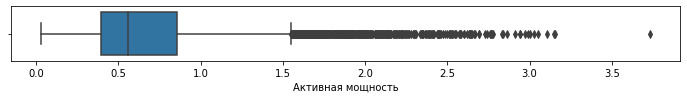

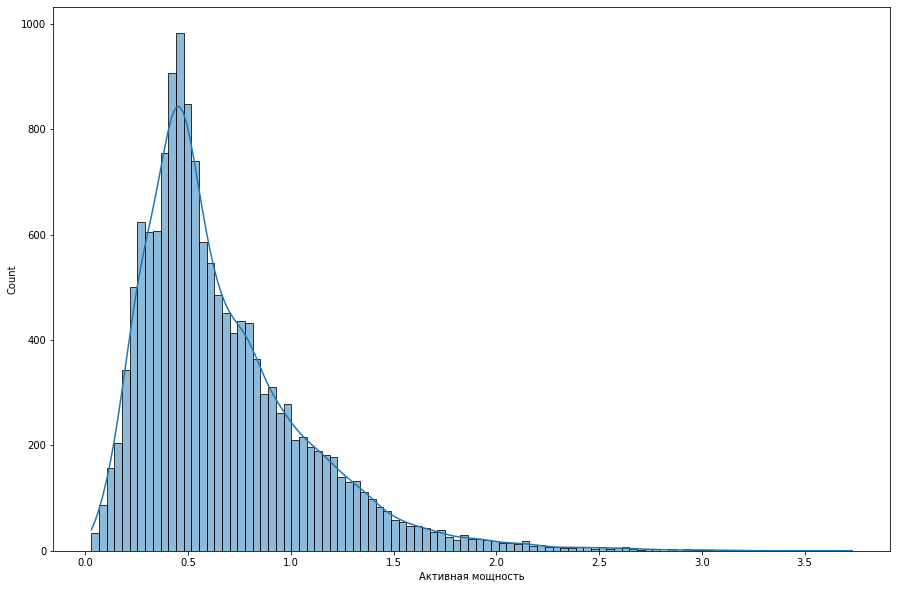

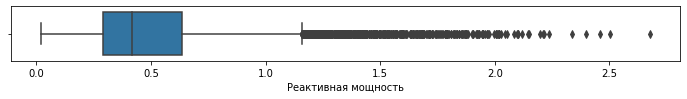

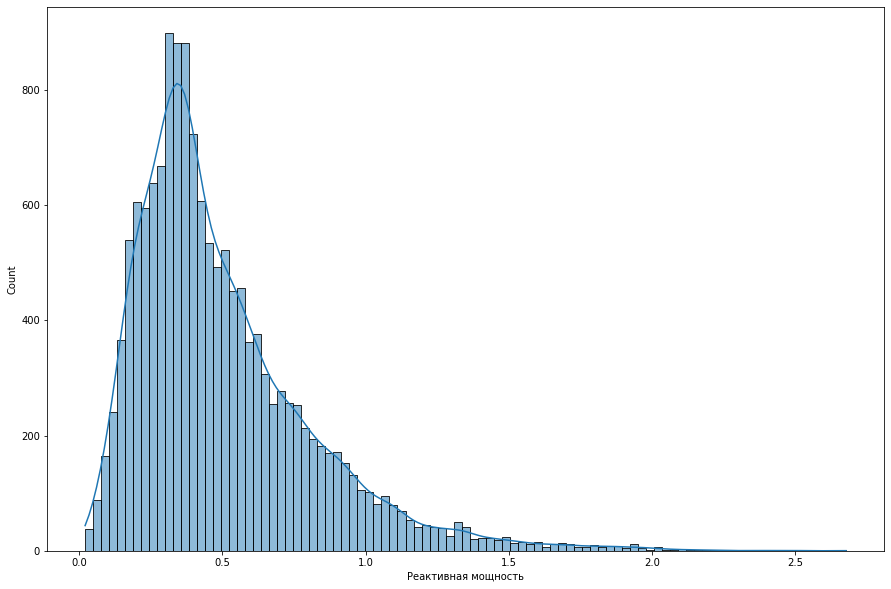

In [10]:
plt.figure(figsize=(12,1))
sns.boxplot(data_arc['Активная мощность'],  orient="h")
plt.show()

plt.figure(figsize=(15,10))
sns.histplot(data_arc['Активная мощность'], kde=True)
plt.show()


plt.figure(figsize=(12,1))
sns.boxplot(data_arc['Реактивная мощность'],  orient="h")
plt.show()

plt.figure(figsize=(15,10))
sns.histplot(data_arc['Реактивная мощность'], kde=True)
plt.show()

 - в показателях мощности есть выбросы в 5-7 раз превышающие медианные значения.

Данные о подаче сыпучих материалов:

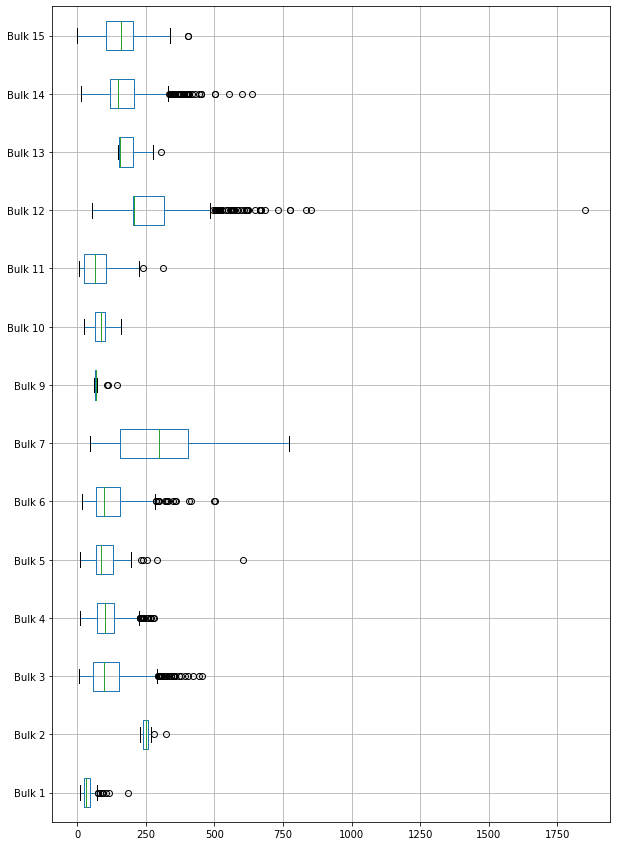

In [11]:
plt.figure(figsize=(10, 15))
data_bulk.boxplot([column for column in data_bulk.columns if column != 'key' and column != 'Bulk 8'], vert=False)
plt.show()

 - Bulk 8 содержит всего одно значение. Партию включающую эту операцию исключим из рассмотрения.
 - Bulk 12 и 5 содержат по одному аномально большому выбросу (так же исключим соответствующие партии из рассмотрения)
 - Bulk 14,12,6,5,3,1 так же содержат некоторое количество выбросов.

**Данные о продувке сплава газом:**

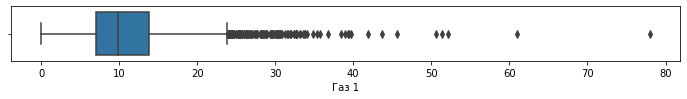

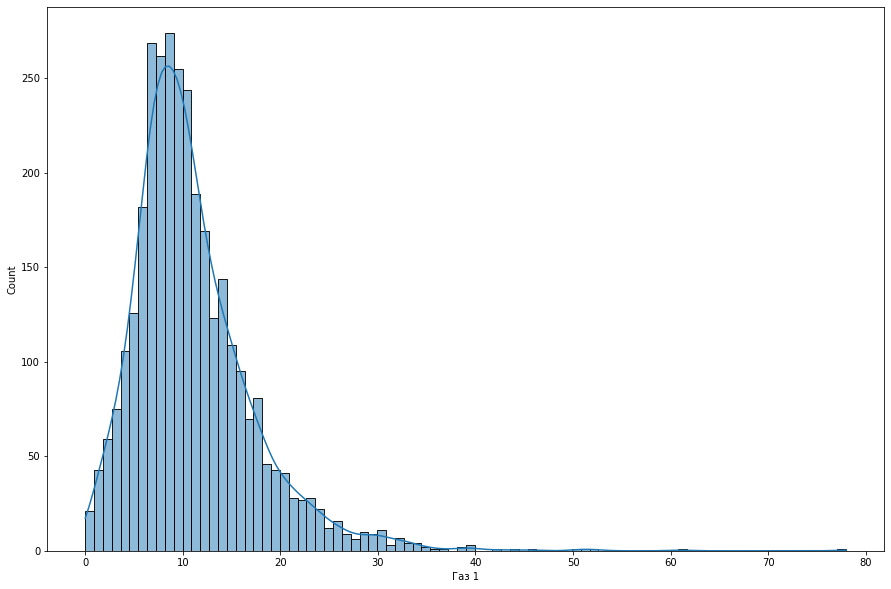

In [12]:
plt.figure(figsize=(12,1))
sns.boxplot(data_gas['Газ 1'],  orient="h")
plt.show()

plt.figure(figsize=(15,10))
sns.histplot(data_gas['Газ 1'], kde=True)
plt.show()

 - есть отдельные выбросы многократно превышающие медианное значение.

Результаты измерения температуры:

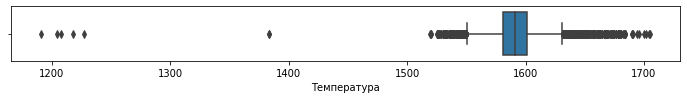

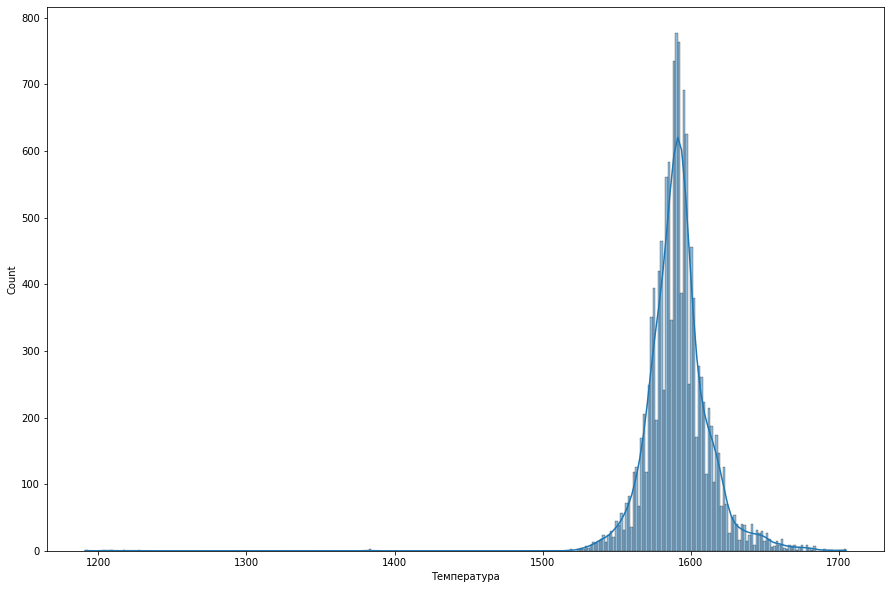

In [13]:
plt.figure(figsize=(12,1))
sns.boxplot(data_temp['Температура'],  orient="h")
plt.show()

plt.figure(figsize=(15,10))
sns.histplot(data_temp['Температура'], kde=True)
plt.show()

 - Так же много выбросов в обе стороны
 - Особенно странно выглядят выбросы в районе температур 1200 градусов - эта температура заведомо ниже температуры плавления железа и большинства (возможно всех) видов стали. Необходимо уточнить у заказчика. 
 - настолько широкий разброс температур (1500-1700) в отлаженном технологическом процессе может говорить о том что в процессе участвуют смеси сильно различающиеся по составу. Учитывая, что мы прогнозируем термодинамическую характеристику, отсутствие данных о составе (в случае больших различий) может вносить большую погрешность. 

**Данные о проволочных материалах:**

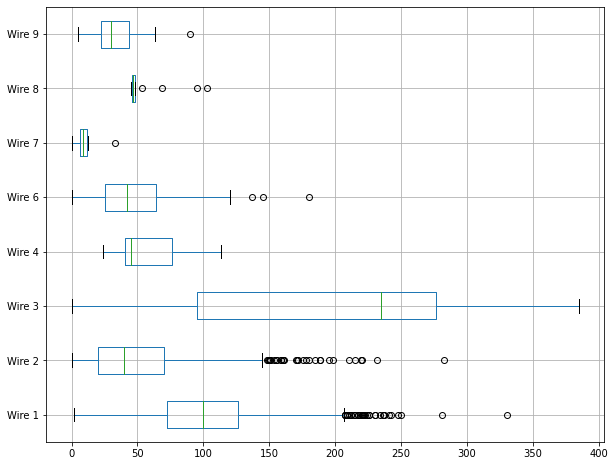

In [14]:
plt.figure(figsize=(10, 8))
data_wire.boxplot([column for column in data_wire.columns if column != 'key' and column != 'Wire 5'], vert=False)
plt.show()

- Wire 5 содержит всего одно значение. Партию включающую эту операцию исключим из рассмотрения.
- Wire 9,8,7,6,2,1 имеют выбросы. Самые экстремальные из них имеет смысл удалить.

Выводы:

 - Все строки с одинаковым значением "Key" соответствуют одной партии. При этом мы видим, что в таблицах "Результаты измерения температуры" и "Данные об электродах" примерно по 15 тыс. записей и одинаковые значения "Key" используются в них многократно , а в остальных таблицах (содержащих данные об объемах и времени подачи дополнительных материалов и газа) около 3100 записей и каждое значение "Key" встречается однократно (это предположение необходимо проверить). 
 - Таким образом можно предположить, что процесс обработки одной партии (одной загрузки ковша) включает несколько этапов подогрева и несколько измерений температуры. При этом подача каждого вида проволочных материалов осуществляется не более 1 раза, так же и подача каждого вида сыпучих материалов осущствляется не более 1 раза - время подачи каждого материала указано.
 - Данных о времмени подачи газа нет. Есть только суммарное количество использованного газа. Либо газ подается непрерывно, либо интервально (как и дополнительные материалы). Эту информацию необходимо дополнительно уточнить у заказчика - единицы измерения не указаны, если объемы газа значительные, то это может быть существенным фактором, влияющим на конечную температуру. 

Следовательно: для построения модели предсказывающей температуру (предположительно последнюю - необходимо уточнить у заказчика) нам необходимо объеденить все таблицы в одну в соответствии с номерами партий и выстроить все события в хронологическом порядке (измерение температуры, нагрев, подачу дополнительных материалов и газа). 

 - для этого необходимо проверить соответствие временных интервалов (все события в рамках обработки одной партии должны лежать между первым и последним измерением температуры)

### 2 Проверка хронологической корректности ###

- Проверим наличие первой и последней температур для каждой партии:

In [15]:
first_temp = data_temp.groupby('key').agg('min')['Время замера']
first_temp = data_temp.merge(first_temp, on='Время замера', how='right')
first_temp.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

In [16]:
last_temp = data_temp.groupby('key').agg('max')['Время замера']
last_temp = data_temp.merge(last_temp, on='Время замера', how='right')
last_temp.isna().sum()

key               0
Время замера      0
Температура     739
dtype: int64

- нет пропусков в измерениях первой температуры, но есть 739 пропусков последней температуры (являющейся целевым признаком). Придется удалить все соответствующие партии.

In [17]:
last_temp = last_temp.dropna()

- Объединим данные о первых и последних измерениях температуры в одну таблицу.

In [18]:
temperature = first_temp.merge(last_temp, on='key', how='inner')
temperature.set_axis(['key','first_time','first_temp','last_time','last_temp'], axis = 'columns', inplace = True)

temp_time = temperature.drop(['first_temp','last_temp'], axis=1)

Данные о нагреве (data_arc - "Данные об электродах"):

- время "Начало нагрева дугой" не должно превышать время "Конец нагрева дугой":

In [19]:
data_arc[data_arc['Начало нагрева дугой'] > data_arc['Конец нагрева дугой']].shape

(0, 5)

- ошибок нет.

- Нагрев осуществляется несколько раз для одной партии. Соответственно, для каждой партии возьмем максимальное время "Конец нагрева дугой" и минимальное время "Начало нагрева дугой" (сравнивать будем, соответственно, с последним временем измерения температуры и первым временем измерения температуры):

In [20]:
start_time = data_arc.groupby('key').agg('min')['Начало нагрева дугой']
start_time = data_arc.merge(start_time, on='Начало нагрева дугой', how='right')[['key','Начало нагрева дугой']]

end_time = data_arc.groupby('key').agg('max')['Конец нагрева дугой']
end_time = data_arc.merge(end_time, on='Конец нагрева дугой', how='right')[['key','Конец нагрева дугой']]

heat_time = start_time.merge(end_time, on='key', how='inner')

- Объеденим данные с min/max временем измерения температуры (таб. temperature), данные с min/max временем начала/конца обогрева (таб. heat_time) и данные о времени загрузки насыпных добавок и проволоки (таб. data_bulk_time и data_wire_time) 
- В итоговую таблицу не включаем строки с номерами партий отсутствующими в какой-либо из таблиц
- Добавим столбцы с минималным и максимальным временем по каждой строке
- Сравним эти времена с временем первого и последнего замера температуры

In [21]:
time_comparision = temp_time.merge(heat_time, on='key',how='inner')
time_comparision = time_comparision.merge(data_bulk_time, on='key',how='inner')
time_comparision = time_comparision.merge(data_wire_time, on='key',how='inner')

time_comparision['min_time'] = time_comparision.drop('key', axis=1).min(axis=1)
time_comparision['max_time'] = time_comparision.drop('key', axis=1).max(axis=1)

print('Кол-во партий в которых последняя операция проведена после последнего замера температуры:'
      ,time_comparision[time_comparision['max_time']>time_comparision['last_time']]['key'].count())
print('Кол-во партий в которых первая операция проведена до первого замера температуры:',
      time_comparision[time_comparision['min_time']<time_comparision['first_time']]['key'].count())

Кол-во партий в которых последняя операция проведена после последнего замера температуры: 123
Кол-во партий в которых первая операция проведена до первого замера температуры: 2303


**Для большинства партий стали есть операции, которые были сделаны до первого замера темпаратуры!**
- Вывод: необходимо задать вопрос заказчику - синхронизировано ли время между различными таблицами? Если нет, то можно ли считать, что первое измерение температуры было сделано до всех остальных операций? (Если время синхронизировано, то это означает что почти везде не хватает первого измерения температуры до всех остальных операций и данные не пригодны для построения прогноза).

### 3 Уточняющие вопросы к заказчику ###

1. Мы видим, что для каждой партии товара температура измеряется несколько раз. Это означает, что необходимо уточнить постановку задачи у заказчика:

- какую из этих темепратур мы должны прогнозировать? Только последнюю (измерение по результатам которого сталь извлекается из ковша) или все температуры или все, кроме первой?
- таблица с результатами измерений температуры содержит разные количества измерений для разных партий. Как отличить ситуацию, когда данные пропущены от ситуации, когда измерений действительно было сделано меньше? Всегда ли последнее измерение в таблице является финальным измерением, после которого расплавленная сталь извлекается из ковша?

2. Чем обусловленны выбросы в признаках Bulk, Wire и в подаче газа? 

3. Почему некоторые температуры аномально низкие (ниже температуры плавления железа)? Какие температуры нужно считать ошибочными? Почему разброс температур смеси настолько большой (для отлаженного тех процесса)?

4. Синхронизировано ли время между различными таблицами? Если нет, то можно ли считать, что первое измерение температуры было сделано до всех остальных операций? (Если время синхронизировано, то это означает что почти везде не хватает первого измерения температуры до всех остальных операций и данные не пригодны для построения прогноза).

**По итогам общения с заказчиком вносим уточнения в задачу:**

- Мы прогнозируем только конечную, итоговую температуру для каждой партии. 
- Для прогноза мы можем использовать только первую температуру. Промежуточные замеры температуры не могут быть использованы для прогноза итоговой.
- время между операциями разного типа не синхронизировано (измерение температуры, нагрев, добавление присадок). Первое измерение температуры мы можем считать самой первой операцией с каждой партией, а время последнего измерения самой последней операцией.

### 4 Преобразуем данные: получим дополнительные признаки, уберем лишние для обучения

- Т.к. время между операциями разного типа не синхронизировано, то нет возможности использовать в качестве признаков какие-либо временные связи (например время между последним нагревом и измерением температуры имеет значение, однако фактически у нас нет этой информации, т.к. фиксации времени этих двух операций не синхронизированы)
- Следовательно имеет смысл использовать суммарную энергию на нагрев для каждой партии - нет смысла считать мощность потому что время нагрева везде разное. (т.е. по всей партии (одно значение 'key') сумма произведений мощности на время для каждой операции нагрева)

In [22]:
data_arc.head()
data_arc['Длительность нагрева'] = (data_arc['Конец нагрева дугой'] 
                                    - data_arc['Начало нагрева дугой']).apply(pd.Timedelta.total_seconds)
data_arc['Активная энергия'] = data_arc['Длительность нагрева'] * data_arc['Активная мощность']
data_arc['Реактивная энергия'] = data_arc['Длительность нагрева'] * data_arc['Реактивная мощность']

heat_full = data_arc.groupby('key').agg(
    act_energy=('Активная энергия','sum'),
    react_energy=('Реактивная энергия','sum'),
    sum_heat_time=('Длительность нагрева','sum')).reset_index()

heat_full.head()

,key,act_energy,react_energy,sum_heat_time
0,1,1207.804249,787.907510,1098.0
1,2,733.816470,487.590677,811.0
2,3,443.583327,280.936835,655.0
3,4,670.663327,429.935932,741.0
4,5,997.496095,664.940090,869.0


- Активная и реактивная мощности должны сильно коррелировать, проверим:

In [23]:
heat_full[['act_energy','react_energy']].corr(method='spearman')

,act_energy,react_energy
act_energy,1.000000,0.985929
react_energy,0.985929,1.000000


- Гипотеза подтверждена. Кроме того на нагрев должна идти только активная мощность. Таким образом реактивная мощность не нужна для обучения моделей. Удалим соответствующий признак:

In [24]:
heat_full = heat_full.drop('react_energy', axis=1)

В таблице temperature (содержит первую и последнюю температуры):

 - добавим столбец с временем между первым и последним измерением - возможно это будет полезный признак при обучении моделей (для операций одного типа время можно использовать - рассинхронизация только между операциями разного типа).
 
 - удалим столбцы с временем измерения, т.к. они бесполезны.

In [25]:
temperature['time_between_temperatures'] = (temperature['last_time'] 
                            - temperature['first_time']).apply(pd.Timedelta.total_seconds)
temperature = temperature.drop(['first_time','last_time'], axis=1)
temperature.head()

,key,first_temp,last_temp,time_between_temperatures
0,1,1571.0,1613.0,861.0
1,2,1581.0,1602.0,1305.0
2,3,1596.0,1599.0,1300.0
3,4,1601.0,1625.0,388.0
4,5,1576.0,1602.0,762.0


#### Соберем все данные в одну таблицу подходящую для обучения моделей

In [26]:
data_model = temperature.merge(heat_full, on='key', how='inner')
data_model = data_model.merge(data_bulk, on='key', how='inner')
data_model = data_model.merge(data_gas, on='key', how='inner')
data_model = data_model.merge(data_wire, on='key', how='inner')

data_model = data_model.drop('key', axis=1)
data_model = data_model.fillna(0)

In [27]:
data_model

,first_temp,last_temp,time_between_temperatures,act_energy,sum_heat_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,861.0,1207.804249,1098.0,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,1305.0,733.816470,811.0,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,1300.0,443.583327,655.0,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,388.0,670.663327,741.0,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,762.0,997.496095,869.0,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,1137.0,626.167357,723.0,0.0,0.0,21.0,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,1554.0,1591.0,1618.0,727.868032,940.0,0.0,0.0,0.0,63.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,1571.0,1589.0,717.0,427.535518,569.0,0.0,0.0,0.0,85.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,1591.0,1594.0,1302.0,629.928649,750.0,0.0,0.0,90.0,0.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Проверим наличие коррелирующих признаков:

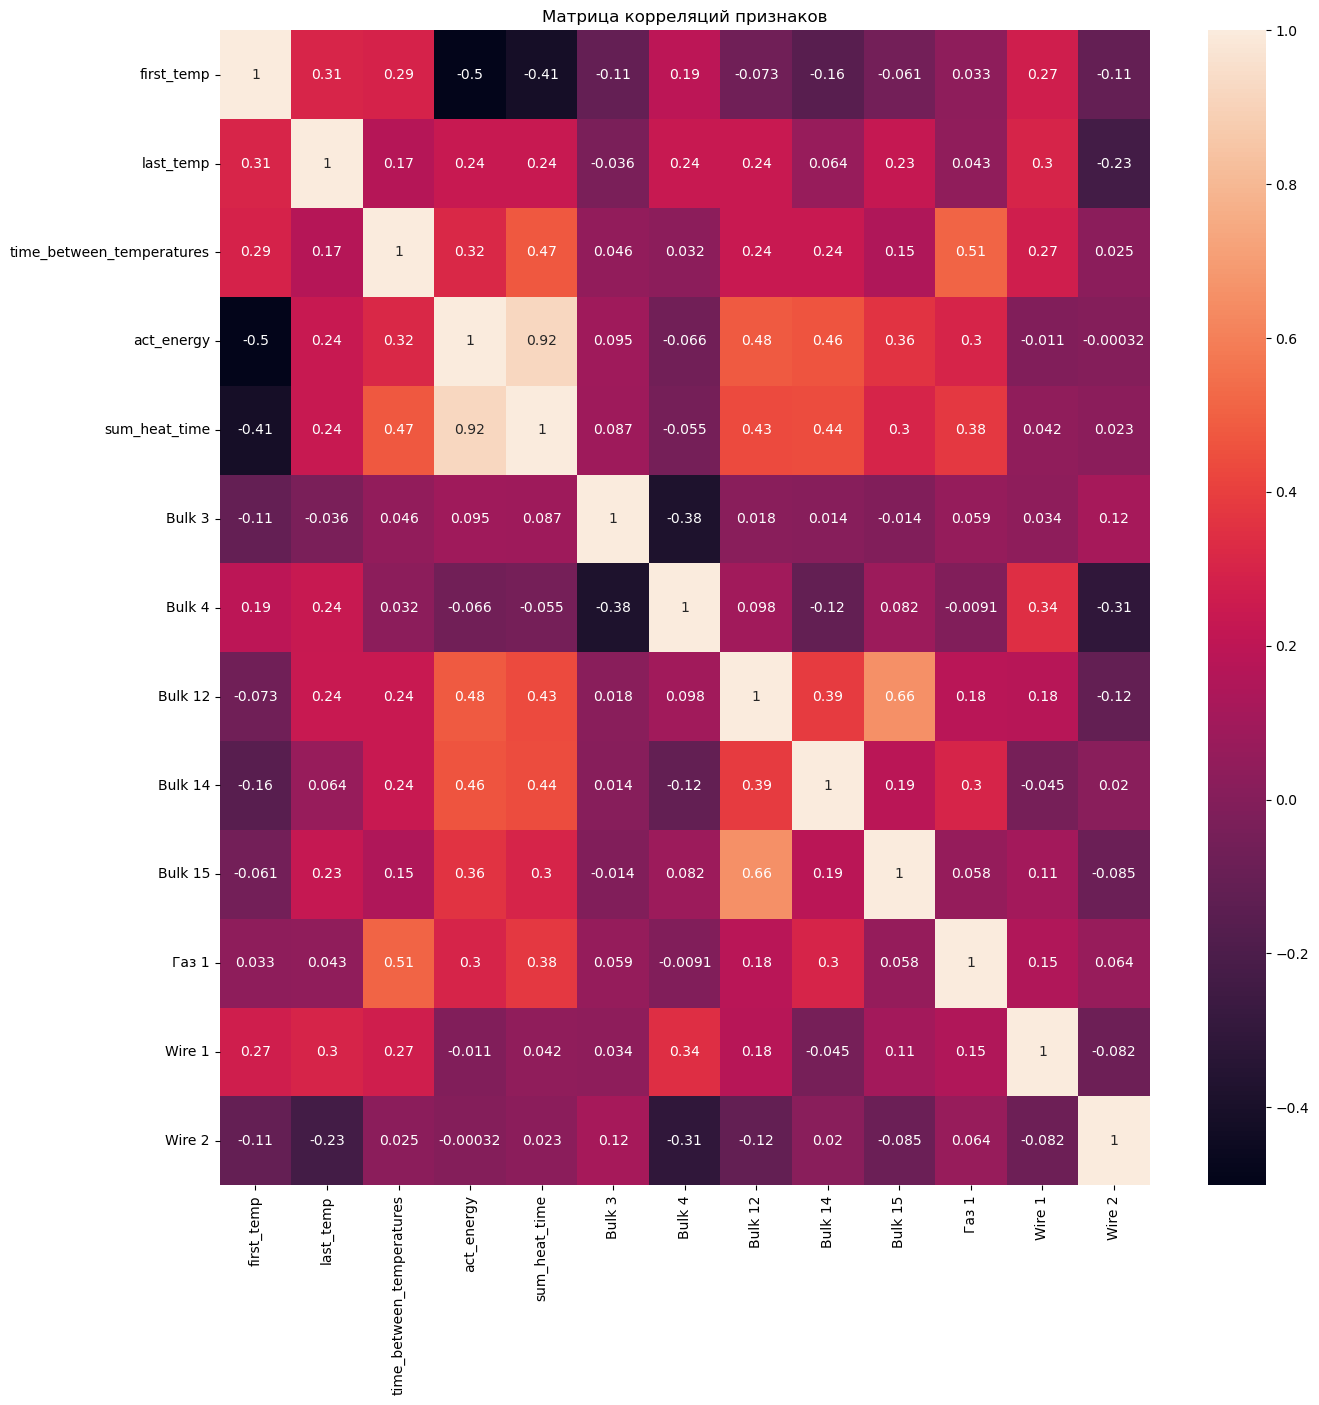

In [29]:
plt.figure(figsize=(15, 15))
plt.title('Матрица корреляций признаков')

sns.heatmap(data_model[['first_temp','last_temp','time_between_temperatures'
                        ,'act_energy','sum_heat_time','Bulk 3','Bulk 4','Bulk 12'
                        ,'Bulk 14','Bulk 15','Газ 1','Wire 1','Wire 2']].corr(method='spearman'), annot = True)

plt.show()


- Высокая корреляция только между признаками "Суммарная активная энергия на нагрев" и "Суммарное время нагрева". Это логично - чем дольше нагревали, тем большее количество энергии передали. 
- Оставим только признак "Суммарное время нагрева", а вместо суммарной энергии будем использовать среднюю мощность - что бы избежать корреляции между признаками и, при этом, не терять важную информацию о мощности нагрева.
- (удалять признак "суммарное время нагрева" мы не хотим - он соизмерим с признаком "время между первым и последним измерением температуры" - возможно это даст дополнительную информацию для модели - это единственный способ хоть как-то учесть время, учитывая что между разными процессами время рассинхронизировано)

In [30]:
data_model['avg_power'] = data_model['act_energy']/data_model['sum_heat_time']
data_model = data_model.drop('act_energy',axis=1)

In [31]:
data_model[['avg_power','sum_heat_time']].corr(method='spearman')

,avg_power,sum_heat_time
avg_power,1.00000,0.66166
sum_heat_time,0.66166,1.00000


- средняя мощность и время нагрева тоже коррелируют, но уже не так сильно (можно предположить, что на производстве, когда возникала необходимость более сильного нагрева использовали как большую мощность так и большее время на нагрев).

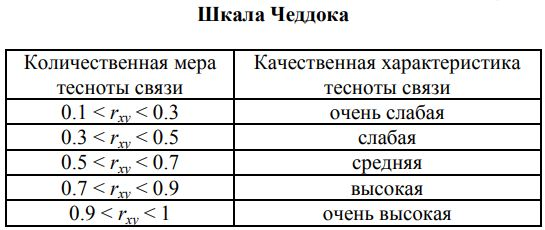

### 5 Обучение моделей

Тренировочная и тестовая выборки:

In [32]:
features = data_model.drop('last_temp', axis=1)
target = data_model['last_temp']

train_features, test_features, train_target, test_target = train_test_split(features, 
                                                                            target,
                                                                            test_size=0.2,
                                                                            random_state=27012023)

Для линейных моделей сделаем масштабирование признаков:

In [33]:
scaler = MinMaxScaler()
scaler.fit(train_features)
X_train = scaler.transform(train_features)
X_test = scaler.transform(test_features)
y_train = train_target
y_test = test_target

Функция для обучения моделей на GridSearchCV:

In [34]:
models = pd.DataFrame({'name':[], 'parameters':[], 'best_MAE_train':[]})

def train_on_grid(model, parameters, name, features, target):
    
    grid_model = GridSearchCV(estimator=model,
                         param_grid=parameters,
                         scoring='neg_mean_absolute_error',
                         cv=3,
                         verbose=1)
    
    grid_model.fit(features, target)
    
    mae = grid_model.best_score_ * -1
    
    models.append([name, grid_model.best_params_, mae])
    
    row = []
    row.extend([name, grid_model.best_params_, mae])
    models.loc[len(models.index)] = row
    
    print('Лучшие параметры:', grid_model.best_params_)
    print('MAE обученной модели:', mae)
    
    return model

**Линейная регрессия**

In [35]:
linear = LinearRegression(n_jobs=-1)
params = {}
linear_model = train_on_grid(linear, params, 'LinearRegression',X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Лучшие параметры: {}
MAE обученной модели: 6.572721780553203


**Lasso**

In [36]:
lasso = Lasso()
params = {'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1.5, 2]}
lasso_model = train_on_grid(lasso, params, 'Lasso', X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Лучшие параметры: {'alpha': 0.01}
MAE обученной модели: 6.420394218752875


**Случайный лес деревьев**

In [37]:
RandomForest = RandomForestRegressor(n_jobs=-1)

params = {
    'max_depth': list(range(20, 31)),
    'n_estimators': [150, 200, 250, 300]
}

rf_model = train_on_grid(RandomForest, params,'RandomForestRegressor', X_train,y_train)

Fitting 3 folds for each of 44 candidates, totalling 132 fits
Лучшие параметры: {'max_depth': 21, 'n_estimators': 300}
MAE обученной модели: 5.967312597712028


**CatBoost**

In [38]:
catboost = CatBoostRegressor(verbose=False)

params = {
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1]
}

catboost_model = train_on_grid(catboost, params,'CatBoostRegressor', X_train,y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 7}
MAE обученной модели: 5.803895820531853


**LGBMRegressor**

In [39]:
lgbm = LGBMRegressor(metric='mae')

params = {
    'max_depth': [3,4,5,6,7,8],
    'learning_rate': [0.01, 0.1, 0.15]
}

lgbm_model = train_on_grid(lgbm, params,'LGBMRegressor', X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 4}
MAE обученной модели: 5.853346307706395


### 6 Выводы

In [40]:
models.head()

,name,parameters,best_MAE_train
0,LinearRegression,{},6.572722
1,Lasso,{'alpha': 0.01},6.420394
2,RandomForestRegressor,"{'max_depth': 21, 'n_estimators': 300}",5.967313
3,CatBoostRegressor,"{'learning_rate': 0.05, 'max_depth': 7}",5.803896
4,LGBMRegressor,"{'learning_rate': 0.1, 'max_depth': 4}",5.853346


**Вывод:** Лучшие результаты на тренировочной выборке показала модель CatBoostRegressor (MAE = 5.804).

**Тест лучшей модели**

In [41]:
catboost_model.fit(train_features, train_target)
predicted = catboost_model.predict(test_features)
mae_on_test = mean_absolute_error(test_target, predicted)
print('MAE на тестовой выборке при использовании GridSearchCV: {:.3f}'.format(mae_on_test))

MAE на тестовой выборке при использовании GridSearchCV: 5.789


**Рассмотрим важность признаков на лучшей модели:**

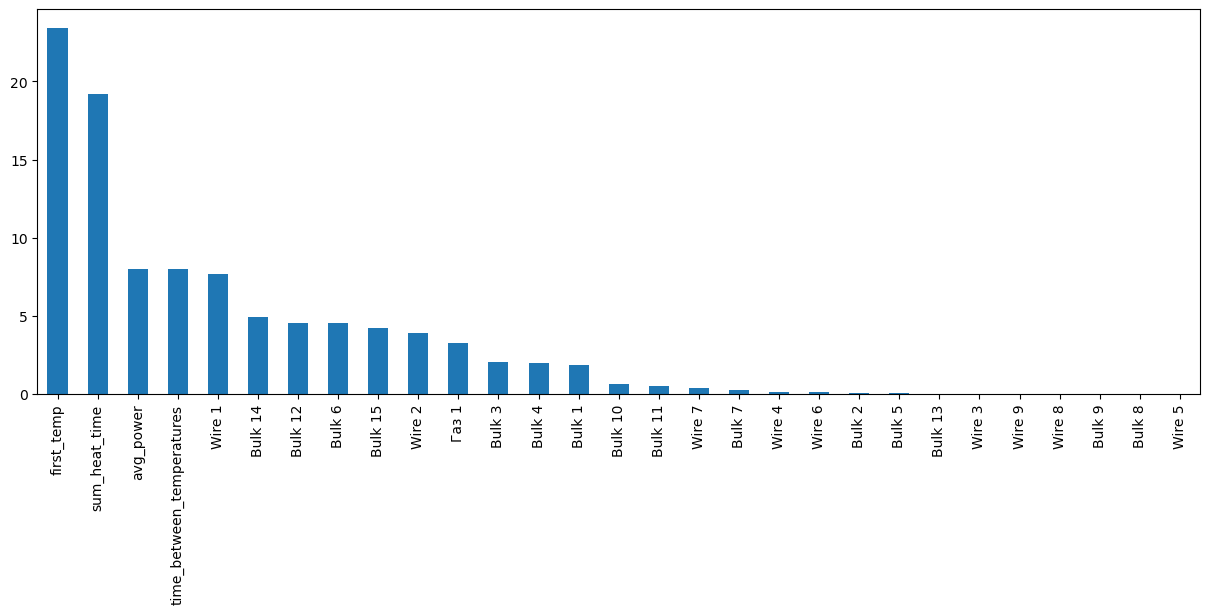

In [42]:
features = pd.Series(catboost_model.feature_importances_, index=train_features.columns).sort_values(ascending=False)

plt.figure(figsize=(15,5))
features.plot.bar()
plt.show()

Итак, параметры оказывающие наибольшее влияние на конечную температуру: 

 - начальная температура
 - время нагрева и мощность нагрева
 - время между первым измерением температуры и последним
 - количество наибольшей добавки (Wire 1)
 

**Выводы:**

 - Найдена модель дающая наилучшие прогнозы (CatBoostRegressor, MAE на тестовой выборке 5.789)
 - Выявлены признаки оказывающие наибольшее влияние на целевой признак (конечную температуру)
 - Выявлены ошибки в указании времени операций различных типов - не синхронизированы часы. 
 - качество прогнозов моделей можно повысить, если синхронизировать время при фиксации операций разного типа
 - все пункты плана были выполнены